In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

In [3]:
livetime = 48 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = ExpCutoffPowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=0.3 * u.Unit("TeV-1"),
    alpha = 1,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.000e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [5]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [6]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [8]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [9]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 34439 
    Total predicted counts          : 34273.14
    Total off counts                : 101691.00

    Total background counts         : 20338.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [11]:

%%time

n_obs = 5000
datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 30.3 s, sys: 319 ms, total: 30.6 s
Wall time: 35.9 s


In [12]:
print(*datasets, sep = "\n") 

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 34383 
    Total predicted counts          : 34347.94
    Total off counts                : 102065.00

    Total background counts         : 20413.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 34005 
    Total predicted counts          : 34232.74
    Total off counts                : 101489.00

    Total background counts         : 20


SpectrumDatasetOnOff

    Name                            : obs_13 

    Total counts                    : 33943 
    Total predicted counts          : 34326.34
    Total off counts                : 101957.00

    Total background counts         : 20391.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 17.47

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_14 

    Total counts                    : 34641 
    Total predicted counts          : 34347.54
    Total off counts                : 102063.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_27 

    Total counts                    : 34084 
    Total predicted counts          : 34302.94
    Total off counts                : 101840.00

    Total background counts         : 20368.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_28 

    Total counts                    : 34273 
    Total predicted counts          : 34309.54
    Total off counts                : 101873.00

    Total background counts         : 


SpectrumDatasetOnOff

    Name                            : obs_44 

    Total counts                    : 34440 
    Total predicted counts          : 34247.14
    Total off counts                : 101561.00

    Total background counts         : 20312.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.41

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_45 

    Total counts                    : 33995 
    Total predicted counts          : 34232.94
    Total off counts                : 101490.00

    Total background counts         :

SpectrumDatasetOnOff

    Name                            : obs_58 

    Total counts                    : 34043 
    Total predicted counts          : 34234.74
    Total off counts                : 101499.00

    Total background counts         : 20299.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_59 

    Total counts                    : 34137 
    Total predicted counts          : 34329.54
    Total off counts                : 101973.00

    Total background counts         : 


SpectrumDatasetOnOff

    Name                            : obs_72 

    Total counts                    : 34152 
    Total predicted counts          : 34295.14
    Total off counts                : 101801.00

    Total background counts         : 20360.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_73 

    Total counts                    : 34635 
    Total predicted counts          : 34187.34
    Total off counts                : 101262.00

    Total background counts         :

SpectrumDatasetOnOff

    Name                            : obs_87 

    Total counts                    : 34385 
    Total predicted counts          : 34266.54
    Total off counts                : 101658.00

    Total background counts         : 20331.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.80

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_88 

    Total counts                    : 34318 
    Total predicted counts          : 34284.94
    Total off counts                : 101750.00

    Total background counts         :

SpectrumDatasetOnOff

    Name                            : obs_104 

    Total counts                    : 33965 
    Total predicted counts          : 34326.54
    Total off counts                : 101958.00

    Total background counts         : 20391.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_105 

    Total counts                    : 34315 
    Total predicted counts          : 34322.14
    Total off counts                : 101936.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_120 

    Total counts                    : 34273 
    Total predicted counts          : 34261.74
    Total off counts                : 101634.00

    Total background counts         : 20326.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_121 

    Total counts                    : 34528 
    Total predicted counts          : 34296.34
    Total off counts                : 101807.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_136 

    Total counts                    : 34117 
    Total predicted counts          : 34271.34
    Total off counts                : 101682.00

    Total background counts         : 20336.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_137 

    Total counts                    : 34677 
    Total predicted counts          : 34222.94
    Total off counts                : 101440.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_150 

    Total counts                    : 34349 
    Total predicted counts          : 34164.54
    Total off counts                : 101148.00

    Total background counts         : 20229.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_151 

    Total counts                    : 34502 
    Total predicted counts          : 34320.94
    Total off counts                : 101930.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_166 

    Total counts                    : 34247 
    Total predicted counts          : 34260.54
    Total off counts                : 101628.00

    Total background counts         : 20325.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.76

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_167 

    Total counts                    : 34408 
    Total predicted counts          : 34252.54
    Total off counts                : 101588.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_180 

    Total counts                    : 34241 
    Total predicted counts          : 34271.54
    Total off counts                : 101683.00

    Total background counts         : 20336.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.68

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_181 

    Total counts                    : 34070 
    Total predicted counts          : 34291.14
    Total off counts                : 101781.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_194 

    Total counts                    : 34101 
    Total predicted counts          : 34224.74
    Total off counts                : 101449.00

    Total background counts         : 20289.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_195 

    Total counts                    : 34164 
    Total predicted counts          : 34264.54
    Total off counts                : 101648.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_208 

    Total counts                    : 33968 
    Total predicted counts          : 34345.94
    Total off counts                : 102055.00

    Total background counts         : 20411.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.23

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_209 

    Total counts                    : 34460 
    Total predicted counts          : 34163.14
    Total off counts                : 101141.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_222 

    Total counts                    : 34307 
    Total predicted counts          : 34257.94
    Total off counts                : 101615.00

    Total background counts         : 20323.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_223 

    Total counts                    : 34271 
    Total predicted counts          : 34262.14
    Total off counts                : 101636.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_236 

    Total counts                    : 33912 
    Total predicted counts          : 34178.94
    Total off counts                : 101220.00

    Total background counts         : 20244.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_237 

    Total counts                    : 34192 
    Total predicted counts          : 34200.74
    Total off counts                : 101329.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_250 

    Total counts                    : 34112 
    Total predicted counts          : 34268.94
    Total off counts                : 101670.00

    Total background counts         : 20334.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.04

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_251 

    Total counts                    : 34409 
    Total predicted counts          : 34293.94
    Total off counts                : 101795.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_264 

    Total counts                    : 34319 
    Total predicted counts          : 34208.14
    Total off counts                : 101366.00

    Total background counts         : 20273.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_265 

    Total counts                    : 34246 
    Total predicted counts          : 34257.74
    Total off counts                : 101614.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_279 

    Total counts                    : 34479 
    Total predicted counts          : 34344.54
    Total off counts                : 102048.00

    Total background counts         : 20409.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.58

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_280 

    Total counts                    : 34008 
    Total predicted counts          : 34145.14
    Total off counts                : 101051.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_293 

    Total counts                    : 34371 
    Total predicted counts          : 34304.34
    Total off counts                : 101847.00

    Total background counts         : 20369.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.14

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_294 

    Total counts                    : 34145 
    Total predicted counts          : 34227.54
    Total off counts                : 101463.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_307 

    Total counts                    : 34465 
    Total predicted counts          : 34304.74
    Total off counts                : 101849.00

    Total background counts         : 20369.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.84

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_308 

    Total counts                    : 34134 
    Total predicted counts          : 34098.14
    Total off counts                : 100816.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_322 

    Total counts                    : 34309 
    Total predicted counts          : 34102.94
    Total off counts                : 100840.00

    Total background counts         : 20168.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_323 

    Total counts                    : 34272 
    Total predicted counts          : 34201.74
    Total off counts                : 101334.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_335 

    Total counts                    : 34437 
    Total predicted counts          : 34262.14
    Total off counts                : 101636.00

    Total background counts         : 20327.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.04

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_336 

    Total counts                    : 34391 
    Total predicted counts          : 34273.14
    Total off counts                : 101691.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_350 

    Total counts                    : 34411 
    Total predicted counts          : 34313.54
    Total off counts                : 101893.00

    Total background counts         : 20378.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_351 

    Total counts                    : 34312 
    Total predicted counts          : 34224.34
    Total off counts                : 101447.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_366 

    Total counts                    : 34131 
    Total predicted counts          : 34235.14
    Total off counts                : 101501.00

    Total background counts         : 20300.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_367 

    Total counts                    : 33799 
    Total predicted counts          : 34207.54
    Total off counts                : 101363.00

    Total background counts        


SpectrumDatasetOnOff

    Name                            : obs_381 

    Total counts                    : 34240 
    Total predicted counts          : 34207.54
    Total off counts                : 101363.00

    Total background counts         : 20272.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_382 

    Total counts                    : 34191 
    Total predicted counts          : 34236.74
    Total off counts                : 101509.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_395 

    Total counts                    : 34232 
    Total predicted counts          : 34238.34
    Total off counts                : 101517.00

    Total background counts         : 20303.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_396 

    Total counts                    : 34387 
    Total predicted counts          : 34206.94
    Total off counts                : 101360.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_410 

    Total counts                    : 34375 
    Total predicted counts          : 34195.74
    Total off counts                : 101304.00

    Total background counts         : 20260.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_411 

    Total counts                    : 34437 
    Total predicted counts          : 34357.54
    Total off counts                : 102113.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_425 

    Total counts                    : 34453 
    Total predicted counts          : 34234.94
    Total off counts                : 101500.00

    Total background counts         : 20300.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.57

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_426 

    Total counts                    : 34330 
    Total predicted counts          : 34296.94
    Total off counts                : 101810.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_438 

    Total counts                    : 34308 
    Total predicted counts          : 34196.34
    Total off counts                : 101307.00

    Total background counts         : 20261.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_439 

    Total counts                    : 34486 
    Total predicted counts          : 34056.14
    Total off counts                : 100606.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_453 

    Total counts                    : 34338 
    Total predicted counts          : 34285.74
    Total off counts                : 101754.00

    Total background counts         : 20350.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_454 

    Total counts                    : 34341 
    Total predicted counts          : 34246.14
    Total off counts                : 101556.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_467 

    Total counts                    : 33984 
    Total predicted counts          : 34345.54
    Total off counts                : 102053.00

    Total background counts         : 20410.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.23

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_468 

    Total counts                    : 34363 
    Total predicted counts          : 34198.34
    Total off counts                : 101317.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_481 

    Total counts                    : 34310 
    Total predicted counts          : 34223.54
    Total off counts                : 101443.00

    Total background counts         : 20288.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_482 

    Total counts                    : 34093 
    Total predicted counts          : 34192.34
    Total off counts                : 101287.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_495 

    Total counts                    : 34485 
    Total predicted counts          : 34191.54
    Total off counts                : 101283.00

    Total background counts         : 20256.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.79

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_496 

    Total counts                    : 34274 
    Total predicted counts          : 34237.54
    Total off counts                : 101513.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_509 

    Total counts                    : 34389 
    Total predicted counts          : 34251.34
    Total off counts                : 101582.00

    Total background counts         : 20316.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_510 

    Total counts                    : 34463 
    Total predicted counts          : 34334.54
    Total off counts                : 101998.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_523 

    Total counts                    : 34012 
    Total predicted counts          : 34244.94
    Total off counts                : 101550.00

    Total background counts         : 20310.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_524 

    Total counts                    : 34272 
    Total predicted counts          : 34357.34
    Total off counts                : 102112.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_537 

    Total counts                    : 34209 
    Total predicted counts          : 34322.54
    Total off counts                : 101938.00

    Total background counts         : 20387.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_538 

    Total counts                    : 34224 
    Total predicted counts          : 34314.94
    Total off counts                : 101900.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_549 

    Total counts                    : 34395 
    Total predicted counts          : 34280.74
    Total off counts                : 101729.00

    Total background counts         : 20345.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_550 

    Total counts                    : 34145 
    Total predicted counts          : 34292.14
    Total off counts                : 101786.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_563 

    Total counts                    : 34285 
    Total predicted counts          : 34180.14
    Total off counts                : 101226.00

    Total background counts         : 20245.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_564 

    Total counts                    : 34158 
    Total predicted counts          : 34277.14
    Total off counts                : 101711.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_577 

    Total counts                    : 34233 
    Total predicted counts          : 34185.34
    Total off counts                : 101252.00

    Total background counts         : 20250.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.04

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_578 

    Total counts                    : 34260 
    Total predicted counts          : 34317.34
    Total off counts                : 101912.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_592 

    Total counts                    : 34499 
    Total predicted counts          : 34256.94
    Total off counts                : 101610.00

    Total background counts         : 20322.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_593 

    Total counts                    : 34112 
    Total predicted counts          : 34194.14
    Total off counts                : 101296.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_606 

    Total counts                    : 34230 
    Total predicted counts          : 34257.14
    Total off counts                : 101611.00

    Total background counts         : 20322.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_607 

    Total counts                    : 34319 
    Total predicted counts          : 34195.74
    Total off counts                : 101304.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_620 

    Total counts                    : 34273 
    Total predicted counts          : 34306.34
    Total off counts                : 101857.00

    Total background counts         : 20371.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_621 

    Total counts                    : 34172 
    Total predicted counts          : 34182.34
    Total off counts                : 101237.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_635 

    Total counts                    : 34322 
    Total predicted counts          : 34255.34
    Total off counts                : 101602.00

    Total background counts         : 20320.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_636 

    Total counts                    : 34662 
    Total predicted counts          : 34197.14
    Total off counts                : 101311.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_649 

    Total counts                    : 34291 
    Total predicted counts          : 34324.54
    Total off counts                : 101948.00

    Total background counts         : 20389.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_650 

    Total counts                    : 34311 
    Total predicted counts          : 34293.34
    Total off counts                : 101792.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_664 

    Total counts                    : 34138 
    Total predicted counts          : 34242.14
    Total off counts                : 101536.00

    Total background counts         : 20307.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.31

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_665 

    Total counts                    : 33853 
    Total predicted counts          : 34252.94
    Total off counts                : 101590.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_678 

    Total counts                    : 34169 
    Total predicted counts          : 34192.34
    Total off counts                : 101287.00

    Total background counts         : 20257.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_679 

    Total counts                    : 34142 
    Total predicted counts          : 34238.54
    Total off counts                : 101518.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_693 

    Total counts                    : 34292 
    Total predicted counts          : 34255.54
    Total off counts                : 101603.00

    Total background counts         : 20320.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_694 

    Total counts                    : 34453 
    Total predicted counts          : 34216.14
    Total off counts                : 101406.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_708 

    Total counts                    : 34218 
    Total predicted counts          : 34206.54
    Total off counts                : 101358.00

    Total background counts         : 20271.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_709 

    Total counts                    : 34476 
    Total predicted counts          : 34162.94
    Total off counts                : 101140.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_721 

    Total counts                    : 33885 
    Total predicted counts          : 34200.34
    Total off counts                : 101327.00

    Total background counts         : 20265.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.59

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_722 

    Total counts                    : 34041 
    Total predicted counts          : 34168.74
    Total off counts                : 101169.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_735 

    Total counts                    : 34143 
    Total predicted counts          : 34279.34
    Total off counts                : 101722.00

    Total background counts         : 20344.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_736 

    Total counts                    : 34235 
    Total predicted counts          : 34229.54
    Total off counts                : 101473.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_750 

    Total counts                    : 34607 
    Total predicted counts          : 34188.54
    Total off counts                : 101268.00

    Total background counts         : 20253.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_751 

    Total counts                    : 34501 
    Total predicted counts          : 34288.14
    Total off counts                : 101766.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_765 

    Total counts                    : 34172 
    Total predicted counts          : 34318.94
    Total off counts                : 101920.00

    Total background counts         : 20384.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_766 

    Total counts                    : 34072 
    Total predicted counts          : 34235.74
    Total off counts                : 101504.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_779 

    Total counts                    : 34411 
    Total predicted counts          : 34257.14
    Total off counts                : 101611.00

    Total background counts         : 20322.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.70

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_780 

    Total counts                    : 34388 
    Total predicted counts          : 34184.74
    Total off counts                : 101249.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_793 

    Total counts                    : 34230 
    Total predicted counts          : 34321.34
    Total off counts                : 101932.00

    Total background counts         : 20386.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_794 

    Total counts                    : 34512 
    Total predicted counts          : 34273.34
    Total off counts                : 101692.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_808 

    Total counts                    : 34315 
    Total predicted counts          : 34213.34
    Total off counts                : 101392.00

    Total background counts         : 20278.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_809 

    Total counts                    : 34304 
    Total predicted counts          : 34235.34
    Total off counts                : 101502.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_823 

    Total counts                    : 34576 
    Total predicted counts          : 34253.14
    Total off counts                : 101591.00

    Total background counts         : 20318.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.85

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_824 

    Total counts                    : 34409 
    Total predicted counts          : 34206.54
    Total off counts                : 101358.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_836 

    Total counts                    : 34728 
    Total predicted counts          : 34190.94
    Total off counts                : 101280.00

    Total background counts         : 20256.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.26

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_837 

    Total counts                    : 34284 
    Total predicted counts          : 34180.54
    Total off counts                : 101228.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_850 

    Total counts                    : 33839 
    Total predicted counts          : 34229.74
    Total off counts                : 101474.00

    Total background counts         : 20294.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.24

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_851 

    Total counts                    : 34244 
    Total predicted counts          : 34227.14
    Total off counts                : 101461.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_864 

    Total counts                    : 34003 
    Total predicted counts          : 34326.34
    Total off counts                : 101957.00

    Total background counts         : 20391.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.47

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_865 

    Total counts                    : 33940 
    Total predicted counts          : 34286.14
    Total off counts                : 101756.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_878 

    Total counts                    : 34115 
    Total predicted counts          : 34203.14
    Total off counts                : 101341.00

    Total background counts         : 20268.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_879 

    Total counts                    : 34263 
    Total predicted counts          : 34195.14
    Total off counts                : 101301.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_891 

    Total counts                    : 33926 
    Total predicted counts          : 34254.74
    Total off counts                : 101599.00

    Total background counts         : 20319.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_892 

    Total counts                    : 34321 
    Total predicted counts          : 34249.74
    Total off counts                : 101574.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_905 

    Total counts                    : 34179 
    Total predicted counts          : 34316.14
    Total off counts                : 101906.00

    Total background counts         : 20381.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_906 

    Total counts                    : 34485 
    Total predicted counts          : 34323.94
    Total off counts                : 101945.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_919 

    Total counts                    : 34012 
    Total predicted counts          : 34255.74
    Total off counts                : 101604.00

    Total background counts         : 20320.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.63

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_920 

    Total counts                    : 34426 
    Total predicted counts          : 34228.74
    Total off counts                : 101469.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_933 

    Total counts                    : 34443 
    Total predicted counts          : 34177.54
    Total off counts                : 101213.00

    Total background counts         : 20242.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.52

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_934 

    Total counts                    : 34152 
    Total predicted counts          : 34252.74
    Total off counts                : 101589.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_947 

    Total counts                    : 34147 
    Total predicted counts          : 34165.54
    Total off counts                : 101153.00

    Total background counts         : 20230.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.38

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_948 

    Total counts                    : 34063 
    Total predicted counts          : 34372.74
    Total off counts                : 102189.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_961 

    Total counts                    : 34418 
    Total predicted counts          : 34217.14
    Total off counts                : 101411.00

    Total background counts         : 20282.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_962 

    Total counts                    : 34109 
    Total predicted counts          : 34197.74
    Total off counts                : 101314.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_977 

    Total counts                    : 33950 
    Total predicted counts          : 34315.54
    Total off counts                : 101903.00

    Total background counts         : 20380.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_978 

    Total counts                    : 34093 
    Total predicted counts          : 34153.34
    Total off counts                : 101092.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_992 

    Total counts                    : 34319 
    Total predicted counts          : 34152.94
    Total off counts                : 101090.00

    Total background counts         : 20218.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.75

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_993 

    Total counts                    : 34048 
    Total predicted counts          : 34160.74
    Total off counts                : 101129.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_1007 

    Total counts                    : 34581 
    Total predicted counts          : 34275.34
    Total off counts                : 101702.00

    Total background counts         : 20340.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.52

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1008 

    Total counts                    : 34296 
    Total predicted counts          : 34304.54
    Total off counts                : 101848.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1023 

    Total counts                    : 34418 
    Total predicted counts          : 34267.74
    Total off counts                : 101664.00

    Total background counts         : 20332.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1024 

    Total counts                    : 33902 
    Total predicted counts          : 34281.94
    Total off counts                : 101735.00

    Total background counts     

SpectrumDatasetOnOff

    Name                            : obs_1036 

    Total counts                    : 34472 
    Total predicted counts          : 34268.94
    Total off counts                : 101670.00

    Total background counts         : 20334.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.11

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1037 

    Total counts                    : 34270 
    Total predicted counts          : 34230.94
    Total off counts                : 101480.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1050 

    Total counts                    : 34332 
    Total predicted counts          : 34230.34
    Total off counts                : 101477.00

    Total background counts         : 20295.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 18.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1051 

    Total counts                    : 33979 
    Total predicted counts          : 34159.94
    Total off counts                : 101125.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1061 

    Total counts                    : 34250 
    Total predicted counts          : 34210.54
    Total off counts                : 101378.00

    Total background counts         : 20275.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.99

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1062 

    Total counts                    : 33884 
    Total predicted counts          : 34262.74
    Total off counts                : 101639.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1076 

    Total counts                    : 33810 
    Total predicted counts          : 34303.94
    Total off counts                : 101845.00

    Total background counts         : 20369.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1077 

    Total counts                    : 34196 
    Total predicted counts          : 34239.14
    Total off counts                : 101521.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1090 

    Total counts                    : 34600 
    Total predicted counts          : 34166.14
    Total off counts                : 101156.00

    Total background counts         : 20231.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 19.32

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1091 

    Total counts                    : 34197 
    Total predicted counts          : 34199.14
    Total off counts                : 101321.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1105 

    Total counts                    : 34244 
    Total predicted counts          : 34229.14
    Total off counts                : 101471.00

    Total background counts         : 20294.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.76

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1106 

    Total counts                    : 34314 
    Total predicted counts          : 34318.94
    Total off counts                : 101920.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1119 

    Total counts                    : 33938 
    Total predicted counts          : 34318.74
    Total off counts                : 101919.00

    Total background counts         : 20383.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1120 

    Total counts                    : 34368 
    Total predicted counts          : 34247.14
    Total off counts                : 101561.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1133 

    Total counts                    : 34133 
    Total predicted counts          : 34183.94
    Total off counts                : 101245.00

    Total background counts         : 20249.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1134 

    Total counts                    : 34046 
    Total predicted counts          : 34214.54
    Total off counts                : 101398.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1146 

    Total counts                    : 34360 
    Total predicted counts          : 34245.54
    Total off counts                : 101553.00

    Total background counts         : 20310.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1147 

    Total counts                    : 34315 
    Total predicted counts          : 34356.74
    Total off counts                : 102109.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1159 

    Total counts                    : 34122 
    Total predicted counts          : 34195.14
    Total off counts                : 101301.00

    Total background counts         : 20260.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1160 

    Total counts                    : 34059 
    Total predicted counts          : 34263.54
    Total off counts                : 101643.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1173 

    Total counts                    : 34527 
    Total predicted counts          : 34213.14
    Total off counts                : 101391.00

    Total background counts         : 20278.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.40

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1174 

    Total counts                    : 34156 
    Total predicted counts          : 34166.94
    Total off counts                : 101160.00

    Total background counts     

SpectrumDatasetOnOff

    Name                            : obs_1186 

    Total counts                    : 34309 
    Total predicted counts          : 34234.14
    Total off counts                : 101496.00

    Total background counts         : 20299.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1187 

    Total counts                    : 34199 
    Total predicted counts          : 34152.74
    Total off counts                : 101089.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1200 

    Total counts                    : 34096 
    Total predicted counts          : 34182.94
    Total off counts                : 101240.00

    Total background counts         : 20248.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.38

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1201 

    Total counts                    : 34038 
    Total predicted counts          : 34158.14
    Total off counts                : 101116.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_1214 

    Total counts                    : 34395 
    Total predicted counts          : 34308.34
    Total off counts                : 101867.00

    Total background counts         : 20373.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.14

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1215 

    Total counts                    : 34145 
    Total predicted counts          : 34213.74
    Total off counts                : 101394.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1226 

    Total counts                    : 34063 
    Total predicted counts          : 34322.14
    Total off counts                : 101936.00

    Total background counts         : 20387.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.24

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1227 

    Total counts                    : 34292 
    Total predicted counts          : 34223.94
    Total off counts                : 101445.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1239 

    Total counts                    : 34154 
    Total predicted counts          : 34318.54
    Total off counts                : 101918.00

    Total background counts         : 20383.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1240 

    Total counts                    : 34274 
    Total predicted counts          : 34275.94
    Total off counts                : 101705.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1254 

    Total counts                    : 34537 
    Total predicted counts          : 34153.34
    Total off counts                : 101092.00

    Total background counts         : 20218.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.93

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1255 

    Total counts                    : 34083 
    Total predicted counts          : 34271.14
    Total off counts                : 101681.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1268 

    Total counts                    : 33985 
    Total predicted counts          : 34285.54
    Total off counts                : 101753.00

    Total background counts         : 20350.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1269 

    Total counts                    : 34050 
    Total predicted counts          : 34302.14
    Total off counts                : 101836.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1282 

    Total counts                    : 34094 
    Total predicted counts          : 34240.54
    Total off counts                : 101528.00

    Total background counts         : 20305.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.49

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1283 

    Total counts                    : 34335 
    Total predicted counts          : 34400.54
    Total off counts                : 102328.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1295 

    Total counts                    : 34037 
    Total predicted counts          : 34249.74
    Total off counts                : 101574.00

    Total background counts         : 20314.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.89

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1296 

    Total counts                    : 33961 
    Total predicted counts          : 34283.94
    Total off counts                : 101745.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1308 

    Total counts                    : 34105 
    Total predicted counts          : 34253.74
    Total off counts                : 101594.00

    Total background counts         : 20318.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1309 

    Total counts                    : 34114 
    Total predicted counts          : 34273.94
    Total off counts                : 101695.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1320 

    Total counts                    : 34359 
    Total predicted counts          : 34218.74
    Total off counts                : 101419.00

    Total background counts         : 20283.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.76

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1321 

    Total counts                    : 34236 
    Total predicted counts          : 34311.34
    Total off counts                : 101882.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1332 

    Total counts                    : 34329 
    Total predicted counts          : 34317.94
    Total off counts                : 101915.00

    Total background counts         : 20383.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.98

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1333 

    Total counts                    : 34446 
    Total predicted counts          : 34083.94
    Total off counts                : 100745.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1344 

    Total counts                    : 34181 
    Total predicted counts          : 34159.94
    Total off counts                : 101125.00

    Total background counts         : 20225.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.75

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1345 

    Total counts                    : 33875 
    Total predicted counts          : 34164.94
    Total off counts                : 101150.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1359 

    Total counts                    : 34289 
    Total predicted counts          : 34242.74
    Total off counts                : 101539.00

    Total background counts         : 20307.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.51

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1360 

    Total counts                    : 33921 
    Total predicted counts          : 34226.54
    Total off counts                : 101458.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1372 

    Total counts                    : 34110 
    Total predicted counts          : 34291.74
    Total off counts                : 101784.00

    Total background counts         : 20356.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.24

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1373 

    Total counts                    : 34495 
    Total predicted counts          : 34264.74
    Total off counts                : 101649.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1384 

    Total counts                    : 34364 
    Total predicted counts          : 34315.34
    Total off counts                : 101902.00

    Total background counts         : 20380.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1385 

    Total counts                    : 34259 
    Total predicted counts          : 34257.74
    Total off counts                : 101614.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1401 

    Total counts                    : 34305 
    Total predicted counts          : 34124.14
    Total off counts                : 100946.00

    Total background counts         : 20189.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.38

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1402 

    Total counts                    : 34217 
    Total predicted counts          : 34314.74
    Total off counts                : 101899.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1418 

    Total counts                    : 34258 
    Total predicted counts          : 34247.34
    Total off counts                : 101562.00

    Total background counts         : 20312.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1419 

    Total counts                    : 34310 
    Total predicted counts          : 34232.14
    Total off counts                : 101486.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1433 

    Total counts                    : 34378 
    Total predicted counts          : 34166.74
    Total off counts                : 101159.00

    Total background counts         : 20231.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.76

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1434 

    Total counts                    : 34136 
    Total predicted counts          : 34230.34
    Total off counts                : 101477.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1450 

    Total counts                    : 34329 
    Total predicted counts          : 34205.34
    Total off counts                : 101352.00

    Total background counts         : 20270.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.63

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1451 

    Total counts                    : 34190 
    Total predicted counts          : 34162.54
    Total off counts                : 101138.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1467 

    Total counts                    : 34457 
    Total predicted counts          : 34201.54
    Total off counts                : 101333.00

    Total background counts         : 20266.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.00

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1468 

    Total counts                    : 34236 
    Total predicted counts          : 34354.74
    Total off counts                : 102099.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1482 

    Total counts                    : 34113 
    Total predicted counts          : 34159.74
    Total off counts                : 101124.00

    Total background counts         : 20224.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.32

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1483 

    Total counts                    : 34609 
    Total predicted counts          : 34303.94
    Total off counts                : 101845.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1500 

    Total counts                    : 34228 
    Total predicted counts          : 34260.74
    Total off counts                : 101629.00

    Total background counts         : 20325.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1501 

    Total counts                    : 34088 
    Total predicted counts          : 34316.34
    Total off counts                : 101907.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1516 

    Total counts                    : 34505 
    Total predicted counts          : 34275.54
    Total off counts                : 101703.00

    Total background counts         : 20340.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.50

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1517 

    Total counts                    : 34316 
    Total predicted counts          : 34298.94
    Total off counts                : 101820.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_1531 

    Total counts                    : 34579 
    Total predicted counts          : 34421.74
    Total off counts                : 102434.00

    Total background counts         : 20486.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1532 

    Total counts                    : 34455 
    Total predicted counts          : 34224.34
    Total off counts                : 101447.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1546 

    Total counts                    : 34107 
    Total predicted counts          : 34295.94
    Total off counts                : 101805.00

    Total background counts         : 20361.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.12

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1547 

    Total counts                    : 34010 
    Total predicted counts          : 34263.14
    Total off counts                : 101641.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1561 

    Total counts                    : 34734 
    Total predicted counts          : 34277.74
    Total off counts                : 101714.00

    Total background counts         : 20342.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1562 

    Total counts                    : 34446 
    Total predicted counts          : 34154.94
    Total off counts                : 101100.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1577 

    Total counts                    : 33965 
    Total predicted counts          : 34183.34
    Total off counts                : 101242.00

    Total background counts         : 20248.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1578 

    Total counts                    : 34054 
    Total predicted counts          : 34277.94
    Total off counts                : 101715.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1591 

    Total counts                    : 34167 
    Total predicted counts          : 34112.54
    Total off counts                : 100888.00

    Total background counts         : 20177.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1592 

    Total counts                    : 34286 
    Total predicted counts          : 34126.54
    Total off counts                : 100958.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1607 

    Total counts                    : 34398 
    Total predicted counts          : 34296.14
    Total off counts                : 101806.00

    Total background counts         : 20361.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.40

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1608 

    Total counts                    : 34317 
    Total predicted counts          : 34241.94
    Total off counts                : 101535.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1624 

    Total counts                    : 34447 
    Total predicted counts          : 34194.54
    Total off counts                : 101298.00

    Total background counts         : 20259.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.12

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1625 

    Total counts                    : 34134 
    Total predicted counts          : 34130.54
    Total off counts                : 100978.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1641 

    Total counts                    : 34256 
    Total predicted counts          : 34217.94
    Total off counts                : 101415.00

    Total background counts         : 20283.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1642 

    Total counts                    : 34575 
    Total predicted counts          : 34344.94
    Total off counts                : 102050.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1656 

    Total counts                    : 34062 
    Total predicted counts          : 34337.94
    Total off counts                : 102015.00

    Total background counts         : 20403.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.04

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1657 

    Total counts                    : 34303 
    Total predicted counts          : 34284.14
    Total off counts                : 101746.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1668 

    Total counts                    : 34557 
    Total predicted counts          : 34260.74
    Total off counts                : 101629.00

    Total background counts         : 20325.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.72

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1669 

    Total counts                    : 34380 
    Total predicted counts          : 34248.94
    Total off counts                : 101570.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1680 

    Total counts                    : 33928 
    Total predicted counts          : 34242.54
    Total off counts                : 101538.00

    Total background counts         : 20307.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.00

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1681 

    Total counts                    : 33806 
    Total predicted counts          : 34292.14
    Total off counts                : 101786.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1691 

    Total counts                    : 34292 
    Total predicted counts          : 34217.94
    Total off counts                : 101415.00

    Total background counts         : 20283.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.12

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1692 

    Total counts                    : 34237 
    Total predicted counts          : 34273.54
    Total off counts                : 101693.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1715 

    Total counts                    : 34124 
    Total predicted counts          : 34350.14
    Total off counts                : 102076.00

    Total background counts         : 20415.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.83

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1716 

    Total counts                    : 34694 
    Total predicted counts          : 34263.74
    Total off counts                : 101644.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1733 

    Total counts                    : 34052 
    Total predicted counts          : 34286.34
    Total off counts                : 101757.00

    Total background counts         : 20351.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1734 

    Total counts                    : 34183 
    Total predicted counts          : 34243.74
    Total off counts                : 101544.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1750 

    Total counts                    : 34255 
    Total predicted counts          : 34036.34
    Total off counts                : 100507.00

    Total background counts         : 20101.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 17.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1751 

    Total counts                    : 34258 
    Total predicted counts          : 34175.94
    Total off counts                : 101205.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1765 

    Total counts                    : 34289 
    Total predicted counts          : 34364.74
    Total off counts                : 102149.00

    Total background counts         : 20429.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.32

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1766 

    Total counts                    : 34379 
    Total predicted counts          : 34204.14
    Total off counts                : 101346.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1782 

    Total counts                    : 34451 
    Total predicted counts          : 34364.34
    Total off counts                : 102147.00

    Total background counts         : 20429.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.83

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1783 

    Total counts                    : 34258 
    Total predicted counts          : 34326.34
    Total off counts                : 101957.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1800 

    Total counts                    : 34486 
    Total predicted counts          : 34344.74
    Total off counts                : 102049.00

    Total background counts         : 20409.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.98

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1801 

    Total counts                    : 34308 
    Total predicted counts          : 34269.74
    Total off counts                : 101674.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1816 

    Total counts                    : 34260 
    Total predicted counts          : 34260.14
    Total off counts                : 101626.00

    Total background counts         : 20325.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1817 

    Total counts                    : 34305 
    Total predicted counts          : 34295.74
    Total off counts                : 101804.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1830 

    Total counts                    : 34350 
    Total predicted counts          : 34180.34
    Total off counts                : 101227.00

    Total background counts         : 20245.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1831 

    Total counts                    : 34373 
    Total predicted counts          : 34197.34
    Total off counts                : 101312.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1844 

    Total counts                    : 34313 
    Total predicted counts          : 34285.94
    Total off counts                : 101755.00

    Total background counts         : 20351.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1845 

    Total counts                    : 34183 
    Total predicted counts          : 34203.34
    Total off counts                : 101342.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1859 

    Total counts                    : 34197 
    Total predicted counts          : 34308.94
    Total off counts                : 101870.00

    Total background counts         : 20374.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.23

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1860 

    Total counts                    : 34399 
    Total predicted counts          : 34274.74
    Total off counts                : 101699.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1874 

    Total counts                    : 34496 
    Total predicted counts          : 34228.14
    Total off counts                : 101466.00

    Total background counts         : 20293.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1875 

    Total counts                    : 34449 
    Total predicted counts          : 34223.34
    Total off counts                : 101442.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1889 

    Total counts                    : 34007 
    Total predicted counts          : 34280.74
    Total off counts                : 101729.00

    Total background counts         : 20345.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1890 

    Total counts                    : 34128 
    Total predicted counts          : 34282.34
    Total off counts                : 101737.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1905 

    Total counts                    : 34362 
    Total predicted counts          : 34209.54
    Total off counts                : 101373.00

    Total background counts         : 20274.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.40

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1906 

    Total counts                    : 34527 
    Total predicted counts          : 34362.14
    Total off counts                : 102136.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1921 

    Total counts                    : 34128 
    Total predicted counts          : 34182.54
    Total off counts                : 101238.00

    Total background counts         : 20247.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1922 

    Total counts                    : 34305 
    Total predicted counts          : 34249.94
    Total off counts                : 101575.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1936 

    Total counts                    : 34329 
    Total predicted counts          : 34346.74
    Total off counts                : 102059.00

    Total background counts         : 20411.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.70

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1937 

    Total counts                    : 34250 
    Total predicted counts          : 34237.54
    Total off counts                : 101513.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1951 

    Total counts                    : 34216 
    Total predicted counts          : 34292.94
    Total off counts                : 101790.00

    Total background counts         : 20358.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1952 

    Total counts                    : 34446 
    Total predicted counts          : 34319.34
    Total off counts                : 101922.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1966 

    Total counts                    : 34531 
    Total predicted counts          : 34256.14
    Total off counts                : 101606.00

    Total background counts         : 20321.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1967 

    Total counts                    : 34444 
    Total predicted counts          : 34344.74
    Total off counts                : 102049.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1980 

    Total counts                    : 34210 
    Total predicted counts          : 34401.94
    Total off counts                : 102335.00

    Total background counts         : 20467.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1981 

    Total counts                    : 34097 
    Total predicted counts          : 34237.14
    Total off counts                : 101511.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1995 

    Total counts                    : 33960 
    Total predicted counts          : 34236.74
    Total off counts                : 101509.00

    Total background counts         : 20301.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1996 

    Total counts                    : 34117 
    Total predicted counts          : 34268.94
    Total off counts                : 101670.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2010 

    Total counts                    : 34150 
    Total predicted counts          : 34206.14
    Total off counts                : 101356.00

    Total background counts         : 20271.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2011 

    Total counts                    : 34227 
    Total predicted counts          : 34154.54
    Total off counts                : 101098.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2025 

    Total counts                    : 34335 
    Total predicted counts          : 34402.54
    Total off counts                : 102338.00

    Total background counts         : 20467.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2026 

    Total counts                    : 33895 
    Total predicted counts          : 34215.34
    Total off counts                : 101402.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2040 

    Total counts                    : 34150 
    Total predicted counts          : 34242.14
    Total off counts                : 101536.00

    Total background counts         : 20307.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.50

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2041 

    Total counts                    : 33890 
    Total predicted counts          : 34222.14
    Total off counts                : 101436.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2056 

    Total counts                    : 34642 
    Total predicted counts          : 34230.94
    Total off counts                : 101480.00

    Total background counts         : 20296.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.00

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2057 

    Total counts                    : 34406 
    Total predicted counts          : 34114.74
    Total off counts                : 100899.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2071 

    Total counts                    : 34129 
    Total predicted counts          : 34282.14
    Total off counts                : 101736.00

    Total background counts         : 20347.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.51

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2072 

    Total counts                    : 34305 
    Total predicted counts          : 34281.74
    Total off counts                : 101734.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2086 

    Total counts                    : 34408 
    Total predicted counts          : 34235.14
    Total off counts                : 101501.00

    Total background counts         : 20300.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2087 

    Total counts                    : 34144 
    Total predicted counts          : 34297.94
    Total off counts                : 101815.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2101 

    Total counts                    : 34417 
    Total predicted counts          : 34114.74
    Total off counts                : 100899.00

    Total background counts         : 20179.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2102 

    Total counts                    : 34526 
    Total predicted counts          : 34199.94
    Total off counts                : 101325.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2115 

    Total counts                    : 34182 
    Total predicted counts          : 34180.54
    Total off counts                : 101228.00

    Total background counts         : 20245.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2116 

    Total counts                    : 34647 
    Total predicted counts          : 34168.74
    Total off counts                : 101169.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2129 

    Total counts                    : 34105 
    Total predicted counts          : 34259.94
    Total off counts                : 101625.00

    Total background counts         : 20325.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.24

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2130 

    Total counts                    : 34575 
    Total predicted counts          : 34327.74
    Total off counts                : 101964.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2144 

    Total counts                    : 34412 
    Total predicted counts          : 34223.74
    Total off counts                : 101444.00

    Total background counts         : 20288.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.55

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2145 

    Total counts                    : 33859 
    Total predicted counts          : 34223.34
    Total off counts                : 101442.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2158 

    Total counts                    : 34513 
    Total predicted counts          : 34224.54
    Total off counts                : 101448.00

    Total background counts         : 20289.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.31

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2159 

    Total counts                    : 34307 
    Total predicted counts          : 34259.74
    Total off counts                : 101624.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2170 

    Total counts                    : 34765 
    Total predicted counts          : 34172.54
    Total off counts                : 101188.00

    Total background counts         : 20237.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 17.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2171 

    Total counts                    : 34470 
    Total predicted counts          : 34346.34
    Total off counts                : 102057.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2183 

    Total counts                    : 33770 
    Total predicted counts          : 34284.34
    Total off counts                : 101747.00

    Total background counts         : 20349.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.75

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2184 

    Total counts                    : 34288 
    Total predicted counts          : 34195.34
    Total off counts                : 101302.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2198 

    Total counts                    : 34171 
    Total predicted counts          : 34267.74
    Total off counts                : 101664.00

    Total background counts         : 20332.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2199 

    Total counts                    : 34291 
    Total predicted counts          : 34198.54
    Total off counts                : 101318.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2213 

    Total counts                    : 34269 
    Total predicted counts          : 34384.74
    Total off counts                : 102249.00

    Total background counts         : 20449.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.93

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2214 

    Total counts                    : 34239 
    Total predicted counts          : 34263.34
    Total off counts                : 101642.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2226 

    Total counts                    : 34269 
    Total predicted counts          : 34239.74
    Total off counts                : 101524.00

    Total background counts         : 20304.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2227 

    Total counts                    : 34122 
    Total predicted counts          : 34348.74
    Total off counts                : 102069.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2240 

    Total counts                    : 34341 
    Total predicted counts          : 34278.34
    Total off counts                : 101717.00

    Total background counts         : 20343.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.55

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2241 

    Total counts                    : 34151 
    Total predicted counts          : 34272.94
    Total off counts                : 101690.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2254 

    Total counts                    : 34087 
    Total predicted counts          : 34293.54
    Total off counts                : 101793.00

    Total background counts         : 20358.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.07

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2255 

    Total counts                    : 34469 
    Total predicted counts          : 34304.54
    Total off counts                : 101848.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2269 

    Total counts                    : 34037 
    Total predicted counts          : 34262.34
    Total off counts                : 101637.00

    Total background counts         : 20327.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.43

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2270 

    Total counts                    : 34370 
    Total predicted counts          : 34344.34
    Total off counts                : 102047.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2283 

    Total counts                    : 34466 
    Total predicted counts          : 34121.34
    Total off counts                : 100932.00

    Total background counts         : 20186.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2284 

    Total counts                    : 34258 
    Total predicted counts          : 34261.54
    Total off counts                : 101633.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2296 

    Total counts                    : 34179 
    Total predicted counts          : 34203.74
    Total off counts                : 101344.00

    Total background counts         : 20268.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2297 

    Total counts                    : 34659 
    Total predicted counts          : 34312.14
    Total off counts                : 101886.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2310 

    Total counts                    : 34273 
    Total predicted counts          : 34367.94
    Total off counts                : 102165.00

    Total background counts         : 20433.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.43

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2311 

    Total counts                    : 33878 
    Total predicted counts          : 34302.94
    Total off counts                : 101840.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2324 

    Total counts                    : 34523 
    Total predicted counts          : 34257.14
    Total off counts                : 101611.00

    Total background counts         : 20322.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2325 

    Total counts                    : 33957 
    Total predicted counts          : 34250.94
    Total off counts                : 101580.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2339 

    Total counts                    : 33925 
    Total predicted counts          : 34319.94
    Total off counts                : 101925.00

    Total background counts         : 20385.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.58

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2340 

    Total counts                    : 34491 
    Total predicted counts          : 34191.14
    Total off counts                : 101281.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2354 

    Total counts                    : 34297 
    Total predicted counts          : 34267.34
    Total off counts                : 101662.00

    Total background counts         : 20332.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2355 

    Total counts                    : 34193 
    Total predicted counts          : 34207.94
    Total off counts                : 101365.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2368 

    Total counts                    : 34320 
    Total predicted counts          : 34181.74
    Total off counts                : 101234.00

    Total background counts         : 20246.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2369 

    Total counts                    : 34174 
    Total predicted counts          : 34194.74
    Total off counts                : 101299.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2384 

    Total counts                    : 34189 
    Total predicted counts          : 34327.14
    Total off counts                : 101961.00

    Total background counts         : 20392.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2385 

    Total counts                    : 34092 
    Total predicted counts          : 34239.14
    Total off counts                : 101521.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2399 

    Total counts                    : 34334 
    Total predicted counts          : 34210.74
    Total off counts                : 101379.00

    Total background counts         : 20275.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2400 

    Total counts                    : 34039 
    Total predicted counts          : 34309.34
    Total off counts                : 101872.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2414 

    Total counts                    : 34059 
    Total predicted counts          : 34315.94
    Total off counts                : 101905.00

    Total background counts         : 20381.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2415 

    Total counts                    : 34054 
    Total predicted counts          : 34183.34
    Total off counts                : 101242.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2430 

    Total counts                    : 33970 
    Total predicted counts          : 34348.94
    Total off counts                : 102070.00

    Total background counts         : 20414.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.43

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2431 

    Total counts                    : 34265 
    Total predicted counts          : 34155.54
    Total off counts                : 101103.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2446 

    Total counts                    : 34015 
    Total predicted counts          : 34213.94
    Total off counts                : 101395.00

    Total background counts         : 20279.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2447 

    Total counts                    : 34294 
    Total predicted counts          : 34285.54
    Total off counts                : 101753.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2461 

    Total counts                    : 34442 
    Total predicted counts          : 34258.74
    Total off counts                : 101619.00

    Total background counts         : 20323.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2462 

    Total counts                    : 34322 
    Total predicted counts          : 34267.34
    Total off counts                : 101662.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2476 

    Total counts                    : 34347 
    Total predicted counts          : 34266.94
    Total off counts                : 101660.00

    Total background counts         : 20332.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.52

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2477 

    Total counts                    : 34133 
    Total predicted counts          : 34243.14
    Total off counts                : 101541.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2491 

    Total counts                    : 34565 
    Total predicted counts          : 34236.54
    Total off counts                : 101508.00

    Total background counts         : 20301.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.49

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2492 

    Total counts                    : 34175 
    Total predicted counts          : 34140.34
    Total off counts                : 101027.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2506 

    Total counts                    : 34349 
    Total predicted counts          : 34294.34
    Total off counts                : 101797.00

    Total background counts         : 20359.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.83

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2507 

    Total counts                    : 34090 
    Total predicted counts          : 34266.34
    Total off counts                : 101657.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2519 

    Total counts                    : 34620 
    Total predicted counts          : 34350.34
    Total off counts                : 102077.00

    Total background counts         : 20415.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2520 

    Total counts                    : 33627 
    Total predicted counts          : 34223.14
    Total off counts                : 101441.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2532 

    Total counts                    : 34234 
    Total predicted counts          : 34369.14
    Total off counts                : 102171.00

    Total background counts         : 20434.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2533 

    Total counts                    : 33933 
    Total predicted counts          : 34182.54
    Total off counts                : 101238.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2546 

    Total counts                    : 34064 
    Total predicted counts          : 34331.34
    Total off counts                : 101982.00

    Total background counts         : 20396.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.26

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2547 

    Total counts                    : 33901 
    Total predicted counts          : 34222.54
    Total off counts                : 101438.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2560 

    Total counts                    : 34069 
    Total predicted counts          : 34171.34
    Total off counts                : 101182.00

    Total background counts         : 20236.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2561 

    Total counts                    : 34303 
    Total predicted counts          : 34196.14
    Total off counts                : 101306.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2574 

    Total counts                    : 34075 
    Total predicted counts          : 34342.54
    Total off counts                : 102038.00

    Total background counts         : 20407.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2575 

    Total counts                    : 34343 
    Total predicted counts          : 34256.14
    Total off counts                : 101606.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2591 

    Total counts                    : 34233 
    Total predicted counts          : 34194.74
    Total off counts                : 101299.00

    Total background counts         : 20259.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.67

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2592 

    Total counts                    : 34328 
    Total predicted counts          : 34179.54
    Total off counts                : 101223.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2609 

    Total counts                    : 34440 
    Total predicted counts          : 34187.74
    Total off counts                : 101264.00

    Total background counts         : 20252.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2610 

    Total counts                    : 34098 
    Total predicted counts          : 34215.14
    Total off counts                : 101401.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2625 

    Total counts                    : 34273 
    Total predicted counts          : 34265.14
    Total off counts                : 101651.00

    Total background counts         : 20330.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2626 

    Total counts                    : 33912 
    Total predicted counts          : 34209.74
    Total off counts                : 101374.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2640 

    Total counts                    : 34235 
    Total predicted counts          : 34220.74
    Total off counts                : 101429.00

    Total background counts         : 20285.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2641 

    Total counts                    : 34475 
    Total predicted counts          : 34244.74
    Total off counts                : 101549.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2655 

    Total counts                    : 34112 
    Total predicted counts          : 34344.74
    Total off counts                : 102049.00

    Total background counts         : 20409.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.58

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2656 

    Total counts                    : 34227 
    Total predicted counts          : 34093.54
    Total off counts                : 100793.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2670 

    Total counts                    : 34242 
    Total predicted counts          : 34212.94
    Total off counts                : 101390.00

    Total background counts         : 20278.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2671 

    Total counts                    : 33948 
    Total predicted counts          : 34175.74
    Total off counts                : 101204.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2684 

    Total counts                    : 34161 
    Total predicted counts          : 34345.94
    Total off counts                : 102055.00

    Total background counts         : 20411.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2685 

    Total counts                    : 34326 
    Total predicted counts          : 34226.54
    Total off counts                : 101458.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2698 

    Total counts                    : 34455 
    Total predicted counts          : 34161.34
    Total off counts                : 101132.00

    Total background counts         : 20226.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2699 

    Total counts                    : 33966 
    Total predicted counts          : 34346.34
    Total off counts                : 102057.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2713 

    Total counts                    : 34160 
    Total predicted counts          : 34147.74
    Total off counts                : 101064.00

    Total background counts         : 20212.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2714 

    Total counts                    : 34026 
    Total predicted counts          : 34152.54
    Total off counts                : 101088.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2728 

    Total counts                    : 34172 
    Total predicted counts          : 34162.54
    Total off counts                : 101138.00

    Total background counts         : 20227.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.82

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2729 

    Total counts                    : 34217 
    Total predicted counts          : 34250.34
    Total off counts                : 101577.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2743 

    Total counts                    : 34352 
    Total predicted counts          : 34285.34
    Total off counts                : 101752.00

    Total background counts         : 20350.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2744 

    Total counts                    : 34239 
    Total predicted counts          : 34204.54
    Total off counts                : 101348.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2757 

    Total counts                    : 34366 
    Total predicted counts          : 34389.14
    Total off counts                : 102271.00

    Total background counts         : 20454.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.50

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2758 

    Total counts                    : 34150 
    Total predicted counts          : 34262.34
    Total off counts                : 101637.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2772 

    Total counts                    : 34177 
    Total predicted counts          : 34227.74
    Total off counts                : 101464.00

    Total background counts         : 20292.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2773 

    Total counts                    : 34089 
    Total predicted counts          : 34290.74
    Total off counts                : 101779.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2787 

    Total counts                    : 34131 
    Total predicted counts          : 34317.94
    Total off counts                : 101915.00

    Total background counts         : 20383.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2788 

    Total counts                    : 34053 
    Total predicted counts          : 34085.14
    Total off counts                : 100751.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2801 

    Total counts                    : 33883 
    Total predicted counts          : 34291.54
    Total off counts                : 101783.00

    Total background counts         : 20356.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.26

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2802 

    Total counts                    : 34237 
    Total predicted counts          : 34349.54
    Total off counts                : 102073.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2815 

    Total counts                    : 33910 
    Total predicted counts          : 34268.34
    Total off counts                : 101667.00

    Total background counts         : 20333.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2816 

    Total counts                    : 34325 
    Total predicted counts          : 34409.14
    Total off counts                : 102371.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2830 

    Total counts                    : 34358 
    Total predicted counts          : 34227.14
    Total off counts                : 101461.00

    Total background counts         : 20292.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.60

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2831 

    Total counts                    : 34129 
    Total predicted counts          : 34378.14
    Total off counts                : 102216.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2844 

    Total counts                    : 34196 
    Total predicted counts          : 34219.54
    Total off counts                : 101423.00

    Total background counts         : 20284.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2845 

    Total counts                    : 34318 
    Total predicted counts          : 34178.34
    Total off counts                : 101217.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2857 

    Total counts                    : 34120 
    Total predicted counts          : 34284.14
    Total off counts                : 101746.00

    Total background counts         : 20349.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.93

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2858 

    Total counts                    : 34132 
    Total predicted counts          : 34171.94
    Total off counts                : 101185.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2871 

    Total counts                    : 34440 
    Total predicted counts          : 34205.34
    Total off counts                : 101352.00

    Total background counts         : 20270.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2872 

    Total counts                    : 34182 
    Total predicted counts          : 34287.54
    Total off counts                : 101763.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2883 

    Total counts                    : 34201 
    Total predicted counts          : 34288.54
    Total off counts                : 101768.00

    Total background counts         : 20353.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2884 

    Total counts                    : 34280 
    Total predicted counts          : 34208.74
    Total off counts                : 101369.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2897 

    Total counts                    : 34246 
    Total predicted counts          : 34285.74
    Total off counts                : 101754.00

    Total background counts         : 20350.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.57

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2898 

    Total counts                    : 34377 
    Total predicted counts          : 34302.94
    Total off counts                : 101840.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2910 

    Total counts                    : 34460 
    Total predicted counts          : 34091.54
    Total off counts                : 100783.00

    Total background counts         : 20156.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.23

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2911 

    Total counts                    : 34444 
    Total predicted counts          : 34161.14
    Total off counts                : 101131.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2924 

    Total counts                    : 34606 
    Total predicted counts          : 34314.14
    Total off counts                : 101896.00

    Total background counts         : 20379.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2925 

    Total counts                    : 34130 
    Total predicted counts          : 34161.74
    Total off counts                : 101134.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2939 

    Total counts                    : 34501 
    Total predicted counts          : 34205.54
    Total off counts                : 101353.00

    Total background counts         : 20270.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2940 

    Total counts                    : 34005 
    Total predicted counts          : 34234.34
    Total off counts                : 101497.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2953 

    Total counts                    : 34109 
    Total predicted counts          : 34311.14
    Total off counts                : 101881.00

    Total background counts         : 20376.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2954 

    Total counts                    : 34452 
    Total predicted counts          : 34211.34
    Total off counts                : 101382.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2968 

    Total counts                    : 34134 
    Total predicted counts          : 34263.74
    Total off counts                : 101644.00

    Total background counts         : 20328.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2969 

    Total counts                    : 34040 
    Total predicted counts          : 34123.34
    Total off counts                : 100942.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2983 

    Total counts                    : 34562 
    Total predicted counts          : 34299.74
    Total off counts                : 101824.00

    Total background counts         : 20364.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.68

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2984 

    Total counts                    : 34339 
    Total predicted counts          : 34273.14
    Total off counts                : 101691.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2997 

    Total counts                    : 34365 
    Total predicted counts          : 34301.54
    Total off counts                : 101833.00

    Total background counts         : 20366.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2998 

    Total counts                    : 34489 
    Total predicted counts          : 34329.94
    Total off counts                : 101975.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3010 

    Total counts                    : 34493 
    Total predicted counts          : 34257.54
    Total off counts                : 101613.00

    Total background counts         : 20322.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.26

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3011 

    Total counts                    : 34351 
    Total predicted counts          : 34136.54
    Total off counts                : 101008.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3024 

    Total counts                    : 34205 
    Total predicted counts          : 34226.14
    Total off counts                : 101456.00

    Total background counts         : 20291.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3025 

    Total counts                    : 34186 
    Total predicted counts          : 34265.54
    Total off counts                : 101653.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3037 

    Total counts                    : 34183 
    Total predicted counts          : 34193.14
    Total off counts                : 101291.00

    Total background counts         : 20258.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.14

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3038 

    Total counts                    : 34324 
    Total predicted counts          : 34364.54
    Total off counts                : 102148.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3050 

    Total counts                    : 34194 
    Total predicted counts          : 34250.74
    Total off counts                : 101579.00

    Total background counts         : 20315.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3051 

    Total counts                    : 34388 
    Total predicted counts          : 34287.74
    Total off counts                : 101764.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3064 

    Total counts                    : 34164 
    Total predicted counts          : 34278.34
    Total off counts                : 101717.00

    Total background counts         : 20343.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.66

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3065 

    Total counts                    : 33935 
    Total predicted counts          : 34262.34
    Total off counts                : 101637.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3078 

    Total counts                    : 34155 
    Total predicted counts          : 34247.14
    Total off counts                : 101561.00

    Total background counts         : 20312.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.70

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3079 

    Total counts                    : 34046 
    Total predicted counts          : 34252.74
    Total off counts                : 101589.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3092 

    Total counts                    : 34353 
    Total predicted counts          : 34252.34
    Total off counts                : 101587.00

    Total background counts         : 20317.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3093 

    Total counts                    : 34283 
    Total predicted counts          : 34186.54
    Total off counts                : 101258.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3106 

    Total counts                    : 34417 
    Total predicted counts          : 34252.74
    Total off counts                : 101589.00

    Total background counts         : 20317.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3107 

    Total counts                    : 34279 
    Total predicted counts          : 34209.54
    Total off counts                : 101373.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3120 

    Total counts                    : 34434 
    Total predicted counts          : 34384.54
    Total off counts                : 102248.00

    Total background counts         : 20449.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3121 

    Total counts                    : 34414 
    Total predicted counts          : 34252.94
    Total off counts                : 101590.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3134 

    Total counts                    : 34848 
    Total predicted counts          : 34314.34
    Total off counts                : 101897.00

    Total background counts         : 20379.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3135 

    Total counts                    : 34547 
    Total predicted counts          : 34138.94
    Total off counts                : 101020.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3147 

    Total counts                    : 34360 
    Total predicted counts          : 34215.54
    Total off counts                : 101403.00

    Total background counts         : 20280.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.52

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3148 

    Total counts                    : 33937 
    Total predicted counts          : 34332.34
    Total off counts                : 101987.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_3161 

    Total counts                    : 34336 
    Total predicted counts          : 34225.94
    Total off counts                : 101455.00

    Total background counts         : 20291.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3162 

    Total counts                    : 34574 
    Total predicted counts          : 34190.94
    Total off counts                : 101280.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3173 

    Total counts                    : 34517 
    Total predicted counts          : 34256.34
    Total off counts                : 101607.00

    Total background counts         : 20321.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3174 

    Total counts                    : 34369 
    Total predicted counts          : 34252.14
    Total off counts                : 101586.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3187 

    Total counts                    : 34502 
    Total predicted counts          : 34289.94
    Total off counts                : 101775.00

    Total background counts         : 20355.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.51

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3188 

    Total counts                    : 34532 
    Total predicted counts          : 34143.94
    Total off counts                : 101045.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3202 

    Total counts                    : 33972 
    Total predicted counts          : 34243.34
    Total off counts                : 101542.00

    Total background counts         : 20308.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3203 

    Total counts                    : 34234 
    Total predicted counts          : 34303.54
    Total off counts                : 101843.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3216 

    Total counts                    : 34547 
    Total predicted counts          : 34196.94
    Total off counts                : 101310.00

    Total background counts         : 20262.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3217 

    Total counts                    : 34375 
    Total predicted counts          : 34309.74
    Total off counts                : 101874.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3230 

    Total counts                    : 34478 
    Total predicted counts          : 34275.74
    Total off counts                : 101704.00

    Total background counts         : 20340.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.66

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3231 

    Total counts                    : 34198 
    Total predicted counts          : 34225.34
    Total off counts                : 101452.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3244 

    Total counts                    : 34295 
    Total predicted counts          : 34204.94
    Total off counts                : 101350.00

    Total background counts         : 20270.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3245 

    Total counts                    : 33942 
    Total predicted counts          : 34321.14
    Total off counts                : 101931.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3259 

    Total counts                    : 34255 
    Total predicted counts          : 34207.74
    Total off counts                : 101364.00

    Total background counts         : 20272.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3260 

    Total counts                    : 34288 
    Total predicted counts          : 34165.74
    Total off counts                : 101154.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3272 

    Total counts                    : 34233 
    Total predicted counts          : 34245.54
    Total off counts                : 101553.00

    Total background counts         : 20310.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3273 

    Total counts                    : 34347 
    Total predicted counts          : 34272.14
    Total off counts                : 101686.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3287 

    Total counts                    : 34448 
    Total predicted counts          : 34369.74
    Total off counts                : 102174.00

    Total background counts         : 20434.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3288 

    Total counts                    : 34115 
    Total predicted counts          : 34230.14
    Total off counts                : 101476.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3302 

    Total counts                    : 34356 
    Total predicted counts          : 34112.74
    Total off counts                : 100889.00

    Total background counts         : 20177.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3303 

    Total counts                    : 34160 
    Total predicted counts          : 34270.54
    Total off counts                : 101678.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3317 

    Total counts                    : 34273 
    Total predicted counts          : 34232.54
    Total off counts                : 101488.00

    Total background counts         : 20297.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.26

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3318 

    Total counts                    : 34187 
    Total predicted counts          : 34287.14
    Total off counts                : 101761.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3332 

    Total counts                    : 33902 
    Total predicted counts          : 34303.34
    Total off counts                : 101842.00

    Total background counts         : 20368.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3333 

    Total counts                    : 34210 
    Total predicted counts          : 34234.34
    Total off counts                : 101497.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3346 

    Total counts                    : 34177 
    Total predicted counts          : 34221.14
    Total off counts                : 101431.00

    Total background counts         : 20286.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3347 

    Total counts                    : 34359 
    Total predicted counts          : 34220.94
    Total off counts                : 101430.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3360 

    Total counts                    : 34068 
    Total predicted counts          : 34230.34
    Total off counts                : 101477.00

    Total background counts         : 20295.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3361 

    Total counts                    : 34284 
    Total predicted counts          : 34146.94
    Total off counts                : 101060.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3374 

    Total counts                    : 34460 
    Total predicted counts          : 34271.34
    Total off counts                : 101682.00

    Total background counts         : 20336.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3375 

    Total counts                    : 34343 
    Total predicted counts          : 34375.54
    Total off counts                : 102203.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3389 

    Total counts                    : 34325 
    Total predicted counts          : 34131.54
    Total off counts                : 100983.00

    Total background counts         : 20196.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.24

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3390 

    Total counts                    : 34255 
    Total predicted counts          : 34249.74
    Total off counts                : 101574.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3404 

    Total counts                    : 34199 
    Total predicted counts          : 34251.94
    Total off counts                : 101585.00

    Total background counts         : 20317.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3405 

    Total counts                    : 34436 
    Total predicted counts          : 34252.74
    Total off counts                : 101589.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3418 

    Total counts                    : 34096 
    Total predicted counts          : 34188.14
    Total off counts                : 101266.00

    Total background counts         : 20253.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.68

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3419 

    Total counts                    : 34478 
    Total predicted counts          : 34101.34
    Total off counts                : 100832.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_3433 

    Total counts                    : 34137 
    Total predicted counts          : 34191.34
    Total off counts                : 101282.00

    Total background counts         : 20256.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3434 

    Total counts                    : 34607 
    Total predicted counts          : 34259.14
    Total off counts                : 101621.00

    Total background counts     

SpectrumDatasetOnOff

    Name                            : obs_3447 

    Total counts                    : 34219 
    Total predicted counts          : 34253.74
    Total off counts                : 101594.00

    Total background counts         : 20318.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3448 

    Total counts                    : 34300 
    Total predicted counts          : 34226.54
    Total off counts                : 101458.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_3462 

    Total counts                    : 34336 
    Total predicted counts          : 34217.14
    Total off counts                : 101411.00

    Total background counts         : 20282.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.70

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3463 

    Total counts                    : 34446 
    Total predicted counts          : 34222.94
    Total off counts                : 101440.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3477 

    Total counts                    : 33745 
    Total predicted counts          : 34125.14
    Total off counts                : 100951.00

    Total background counts         : 20190.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3478 

    Total counts                    : 34145 
    Total predicted counts          : 34303.14
    Total off counts                : 101841.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3491 

    Total counts                    : 34210 
    Total predicted counts          : 34259.34
    Total off counts                : 101622.00

    Total background counts         : 20324.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.99

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3492 

    Total counts                    : 34069 
    Total predicted counts          : 34242.34
    Total off counts                : 101537.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3505 

    Total counts                    : 34197 
    Total predicted counts          : 34223.14
    Total off counts                : 101441.00

    Total background counts         : 20288.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3506 

    Total counts                    : 34076 
    Total predicted counts          : 34325.34
    Total off counts                : 101952.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3520 

    Total counts                    : 34069 
    Total predicted counts          : 34339.74
    Total off counts                : 102024.00

    Total background counts         : 20404.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 17.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3521 

    Total counts                    : 34048 
    Total predicted counts          : 34158.34
    Total off counts                : 101117.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_3536 

    Total counts                    : 33963 
    Total predicted counts          : 34096.14
    Total off counts                : 100806.00

    Total background counts         : 20161.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3537 

    Total counts                    : 34389 
    Total predicted counts          : 34387.14
    Total off counts                : 102261.00

    Total background counts     

SpectrumDatasetOnOff

    Name                            : obs_3551 

    Total counts                    : 34586 
    Total predicted counts          : 34327.94
    Total off counts                : 101965.00

    Total background counts         : 20393.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3552 

    Total counts                    : 34386 
    Total predicted counts          : 34192.34
    Total off counts                : 101287.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3566 

    Total counts                    : 34450 
    Total predicted counts          : 34258.54
    Total off counts                : 101618.00

    Total background counts         : 20323.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3567 

    Total counts                    : 34467 
    Total predicted counts          : 34328.94
    Total off counts                : 101970.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3582 

    Total counts                    : 34308 
    Total predicted counts          : 34420.34
    Total off counts                : 102427.00

    Total background counts         : 20485.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.80

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3583 

    Total counts                    : 34065 
    Total predicted counts          : 34266.34
    Total off counts                : 101657.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3597 

    Total counts                    : 34213 
    Total predicted counts          : 34299.54
    Total off counts                : 101823.00

    Total background counts         : 20364.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3598 

    Total counts                    : 34210 
    Total predicted counts          : 34285.14
    Total off counts                : 101751.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3612 

    Total counts                    : 33887 
    Total predicted counts          : 34320.14
    Total off counts                : 101926.00

    Total background counts         : 20385.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.24

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3613 

    Total counts                    : 34394 
    Total predicted counts          : 34344.74
    Total off counts                : 102049.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3628 

    Total counts                    : 34381 
    Total predicted counts          : 34128.34
    Total off counts                : 100967.00

    Total background counts         : 20193.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.07

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3629 

    Total counts                    : 33987 
    Total predicted counts          : 34280.34
    Total off counts                : 101727.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_3644 

    Total counts                    : 34324 
    Total predicted counts          : 34284.14
    Total off counts                : 101746.00

    Total background counts         : 20349.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3645 

    Total counts                    : 34280 
    Total predicted counts          : 34159.94
    Total off counts                : 101125.00

    Total background counts     

SpectrumDatasetOnOff

    Name                            : obs_3659 

    Total counts                    : 33995 
    Total predicted counts          : 34305.94
    Total off counts                : 101855.00

    Total background counts         : 20371.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3660 

    Total counts                    : 33900 
    Total predicted counts          : 34216.34
    Total off counts                : 101407.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3675 

    Total counts                    : 34357 
    Total predicted counts          : 34298.34
    Total off counts                : 101817.00

    Total background counts         : 20363.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3676 

    Total counts                    : 33989 
    Total predicted counts          : 34270.94
    Total off counts                : 101680.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3691 

    Total counts                    : 34148 
    Total predicted counts          : 34163.54
    Total off counts                : 101143.00

    Total background counts         : 20228.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3692 

    Total counts                    : 34162 
    Total predicted counts          : 34139.34
    Total off counts                : 101022.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_3707 

    Total counts                    : 34168 
    Total predicted counts          : 34203.94
    Total off counts                : 101345.00

    Total background counts         : 20269.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3708 

    Total counts                    : 34558 
    Total predicted counts          : 34252.34
    Total off counts                : 101587.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3722 

    Total counts                    : 34510 
    Total predicted counts          : 34212.74
    Total off counts                : 101389.00

    Total background counts         : 20277.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3723 

    Total counts                    : 34472 
    Total predicted counts          : 34166.74
    Total off counts                : 101159.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3738 

    Total counts                    : 34198 
    Total predicted counts          : 34243.14
    Total off counts                : 101541.00

    Total background counts         : 20308.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3739 

    Total counts                    : 34165 
    Total predicted counts          : 34146.54
    Total off counts                : 101058.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3753 

    Total counts                    : 34104 
    Total predicted counts          : 34163.54
    Total off counts                : 101143.00

    Total background counts         : 20228.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3754 

    Total counts                    : 34437 
    Total predicted counts          : 34179.14
    Total off counts                : 101221.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3769 

    Total counts                    : 34413 
    Total predicted counts          : 34137.14
    Total off counts                : 101011.00

    Total background counts         : 20202.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3770 

    Total counts                    : 34316 
    Total predicted counts          : 34118.74
    Total off counts                : 100919.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3784 

    Total counts                    : 34497 
    Total predicted counts          : 34244.34
    Total off counts                : 101547.00

    Total background counts         : 20309.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3785 

    Total counts                    : 34366 
    Total predicted counts          : 34273.94
    Total off counts                : 101695.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_3800 

    Total counts                    : 34299 
    Total predicted counts          : 34222.94
    Total off counts                : 101440.00

    Total background counts         : 20288.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3801 

    Total counts                    : 33906 
    Total predicted counts          : 34236.94
    Total off counts                : 101510.00

    Total background counts     

SpectrumDatasetOnOff

    Name                            : obs_3815 

    Total counts                    : 34452 
    Total predicted counts          : 34175.54
    Total off counts                : 101203.00

    Total background counts         : 20240.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3816 

    Total counts                    : 34309 
    Total predicted counts          : 34110.34
    Total off counts                : 100877.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3830 

    Total counts                    : 34073 
    Total predicted counts          : 34201.74
    Total off counts                : 101334.00

    Total background counts         : 20266.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.59

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3831 

    Total counts                    : 34379 
    Total predicted counts          : 34165.34
    Total off counts                : 101152.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3844 

    Total counts                    : 34032 
    Total predicted counts          : 34102.14
    Total off counts                : 100836.00

    Total background counts         : 20167.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.38

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3845 

    Total counts                    : 33623 
    Total predicted counts          : 34335.54
    Total off counts                : 102003.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3859 

    Total counts                    : 34262 
    Total predicted counts          : 34243.74
    Total off counts                : 101544.00

    Total background counts         : 20308.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.07

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3860 

    Total counts                    : 34288 
    Total predicted counts          : 34175.94
    Total off counts                : 101205.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3874 

    Total counts                    : 34057 
    Total predicted counts          : 34412.14
    Total off counts                : 102386.00

    Total background counts         : 20477.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.72

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3875 

    Total counts                    : 34534 
    Total predicted counts          : 34239.94
    Total off counts                : 101525.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3887 

    Total counts                    : 33989 
    Total predicted counts          : 34305.14
    Total off counts                : 101851.00

    Total background counts         : 20370.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3888 

    Total counts                    : 34159 
    Total predicted counts          : 34277.34
    Total off counts                : 101712.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3899 

    Total counts                    : 34350 
    Total predicted counts          : 34264.34
    Total off counts                : 101647.00

    Total background counts         : 20329.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3900 

    Total counts                    : 34204 
    Total predicted counts          : 34206.34
    Total off counts                : 101357.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3913 

    Total counts                    : 34157 
    Total predicted counts          : 34225.14
    Total off counts                : 101451.00

    Total background counts         : 20290.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.24

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3914 

    Total counts                    : 34097 
    Total predicted counts          : 34329.54
    Total off counts                : 101973.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3927 

    Total counts                    : 33962 
    Total predicted counts          : 34173.74
    Total off counts                : 101194.00

    Total background counts         : 20238.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3928 

    Total counts                    : 33906 
    Total predicted counts          : 34226.14
    Total off counts                : 101456.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3938 

    Total counts                    : 34043 
    Total predicted counts          : 34301.94
    Total off counts                : 101835.00

    Total background counts         : 20367.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3939 

    Total counts                    : 34385 
    Total predicted counts          : 34197.74
    Total off counts                : 101314.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3953 

    Total counts                    : 34629 
    Total predicted counts          : 34292.54
    Total off counts                : 101788.00

    Total background counts         : 20357.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 18.57

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3954 

    Total counts                    : 34198 
    Total predicted counts          : 34258.74
    Total off counts                : 101619.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3968 

    Total counts                    : 34086 
    Total predicted counts          : 34307.54
    Total off counts                : 101863.00

    Total background counts         : 20372.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.82

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3969 

    Total counts                    : 34080 
    Total predicted counts          : 34240.74
    Total off counts                : 101529.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3983 

    Total counts                    : 34425 
    Total predicted counts          : 34268.54
    Total off counts                : 101668.00

    Total background counts         : 20333.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3984 

    Total counts                    : 34357 
    Total predicted counts          : 34283.14
    Total off counts                : 101741.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3998 

    Total counts                    : 34071 
    Total predicted counts          : 34250.54
    Total off counts                : 101578.00

    Total background counts         : 20315.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3999 

    Total counts                    : 34170 
    Total predicted counts          : 34278.74
    Total off counts                : 101719.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4013 

    Total counts                    : 34178 
    Total predicted counts          : 34186.94
    Total off counts                : 101260.00

    Total background counts         : 20252.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4014 

    Total counts                    : 34098 
    Total predicted counts          : 34180.74
    Total off counts                : 101229.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4026 

    Total counts                    : 34130 
    Total predicted counts          : 34271.54
    Total off counts                : 101683.00

    Total background counts         : 20336.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4027 

    Total counts                    : 33973 
    Total predicted counts          : 34213.74
    Total off counts                : 101394.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4040 

    Total counts                    : 34291 
    Total predicted counts          : 34231.54
    Total off counts                : 101483.00

    Total background counts         : 20296.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4041 

    Total counts                    : 34244 
    Total predicted counts          : 34259.34
    Total off counts                : 101622.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4054 

    Total counts                    : 34363 
    Total predicted counts          : 34285.74
    Total off counts                : 101754.00

    Total background counts         : 20350.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4055 

    Total counts                    : 34188 
    Total predicted counts          : 34232.34
    Total off counts                : 101487.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_4069 

    Total counts                    : 34363 
    Total predicted counts          : 34163.34
    Total off counts                : 101142.00

    Total background counts         : 20228.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4070 

    Total counts                    : 33993 
    Total predicted counts          : 34117.54
    Total off counts                : 100913.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4082 

    Total counts                    : 34468 
    Total predicted counts          : 34251.74
    Total off counts                : 101584.00

    Total background counts         : 20316.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.68

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4083 

    Total counts                    : 34229 
    Total predicted counts          : 34177.74
    Total off counts                : 101214.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4096 

    Total counts                    : 34157 
    Total predicted counts          : 34258.14
    Total off counts                : 101616.00

    Total background counts         : 20323.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4097 

    Total counts                    : 34211 
    Total predicted counts          : 34110.94
    Total off counts                : 100880.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4111 

    Total counts                    : 34560 
    Total predicted counts          : 34187.94
    Total off counts                : 101265.00

    Total background counts         : 20253.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4112 

    Total counts                    : 34275 
    Total predicted counts          : 34272.94
    Total off counts                : 101690.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_4126 

    Total counts                    : 34329 
    Total predicted counts          : 34285.54
    Total off counts                : 101753.00

    Total background counts         : 20350.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4127 

    Total counts                    : 34427 
    Total predicted counts          : 34246.34
    Total off counts                : 101557.00

    Total background counts     


SpectrumDatasetOnOff

    Name                            : obs_4140 

    Total counts                    : 34502 
    Total predicted counts          : 34217.74
    Total off counts                : 101414.00

    Total background counts         : 20282.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.41

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4141 

    Total counts                    : 34207 
    Total predicted counts          : 34245.54
    Total off counts                : 101553.00

    Total background counts     

SpectrumDatasetOnOff

    Name                            : obs_4153 

    Total counts                    : 34439 
    Total predicted counts          : 34326.94
    Total off counts                : 101960.00

    Total background counts         : 20392.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4154 

    Total counts                    : 34270 
    Total predicted counts          : 34390.54
    Total off counts                : 102278.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4168 

    Total counts                    : 34304 
    Total predicted counts          : 34269.54
    Total off counts                : 101673.00

    Total background counts         : 20334.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.38

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4169 

    Total counts                    : 34025 
    Total predicted counts          : 34261.54
    Total off counts                : 101633.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4182 

    Total counts                    : 34227 
    Total predicted counts          : 34209.34
    Total off counts                : 101372.00

    Total background counts         : 20274.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4183 

    Total counts                    : 34292 
    Total predicted counts          : 34176.14
    Total off counts                : 101206.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4195 

    Total counts                    : 34513 
    Total predicted counts          : 34250.74
    Total off counts                : 101579.00

    Total background counts         : 20315.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4196 

    Total counts                    : 34318 
    Total predicted counts          : 34361.54
    Total off counts                : 102133.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4206 

    Total counts                    : 33964 
    Total predicted counts          : 34227.34
    Total off counts                : 101462.00

    Total background counts         : 20292.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.00

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4207 

    Total counts                    : 34452 
    Total predicted counts          : 34258.54
    Total off counts                : 101618.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4222 

    Total counts                    : 34060 
    Total predicted counts          : 34361.14
    Total off counts                : 102131.00

    Total background counts         : 20426.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4223 

    Total counts                    : 34221 
    Total predicted counts          : 34281.34
    Total off counts                : 101732.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4240 

    Total counts                    : 34352 
    Total predicted counts          : 34272.34
    Total off counts                : 101687.00

    Total background counts         : 20337.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4241 

    Total counts                    : 34354 
    Total predicted counts          : 34159.34
    Total off counts                : 101122.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_4258 

    Total counts                    : 34615 
    Total predicted counts          : 34360.94
    Total off counts                : 102130.00

    Total background counts         : 20426.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4259 

    Total counts                    : 34476 
    Total predicted counts          : 34255.94
    Total off counts                : 101605.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_4274 

    Total counts                    : 34125 
    Total predicted counts          : 34230.54
    Total off counts                : 101478.00

    Total background counts         : 20295.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4275 

    Total counts                    : 34243 
    Total predicted counts          : 34235.14
    Total off counts                : 101501.00

    Total background counts     

SpectrumDatasetOnOff

    Name                            : obs_4290 

    Total counts                    : 34763 
    Total predicted counts          : 34346.34
    Total off counts                : 102057.00

    Total background counts         : 20411.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.43

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4291 

    Total counts                    : 34110 
    Total predicted counts          : 34256.34
    Total off counts                : 101607.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4306 

    Total counts                    : 34148 
    Total predicted counts          : 34254.54
    Total off counts                : 101598.00

    Total background counts         : 20319.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4307 

    Total counts                    : 34296 
    Total predicted counts          : 34280.54
    Total off counts                : 101728.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_4322 

    Total counts                    : 34671 
    Total predicted counts          : 34218.34
    Total off counts                : 101417.00

    Total background counts         : 20283.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4323 

    Total counts                    : 34299 
    Total predicted counts          : 34316.14
    Total off counts                : 101906.00

    Total background counts     

SpectrumDatasetOnOff

    Name                            : obs_4337 

    Total counts                    : 34316 
    Total predicted counts          : 34248.74
    Total off counts                : 101569.00

    Total background counts         : 20313.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.98

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4338 

    Total counts                    : 34170 
    Total predicted counts          : 34084.94
    Total off counts                : 100750.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_4354 

    Total counts                    : 34303 
    Total predicted counts          : 34270.14
    Total off counts                : 101676.00

    Total background counts         : 20335.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.66

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4355 

    Total counts                    : 34360 
    Total predicted counts          : 34251.94
    Total off counts                : 101585.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4369 

    Total counts                    : 34259 
    Total predicted counts          : 34188.74
    Total off counts                : 101269.00

    Total background counts         : 20253.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4370 

    Total counts                    : 34126 
    Total predicted counts          : 34264.94
    Total off counts                : 101650.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4384 

    Total counts                    : 34211 
    Total predicted counts          : 34253.14
    Total off counts                : 101591.00

    Total background counts         : 20318.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.59

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4385 

    Total counts                    : 33965 
    Total predicted counts          : 34306.94
    Total off counts                : 101860.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_4400 

    Total counts                    : 34256 
    Total predicted counts          : 34385.54
    Total off counts                : 102253.00

    Total background counts         : 20450.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4401 

    Total counts                    : 34007 
    Total predicted counts          : 34204.54
    Total off counts                : 101348.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4415 

    Total counts                    : 34607 
    Total predicted counts          : 34187.14
    Total off counts                : 101261.00

    Total background counts         : 20252.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4416 

    Total counts                    : 34048 
    Total predicted counts          : 34213.34
    Total off counts                : 101392.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_4433 

    Total counts                    : 34421 
    Total predicted counts          : 34221.14
    Total off counts                : 101431.00

    Total background counts         : 20286.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4434 

    Total counts                    : 34333 
    Total predicted counts          : 34201.34
    Total off counts                : 101332.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4447 

    Total counts                    : 34016 
    Total predicted counts          : 34345.14
    Total off counts                : 102051.00

    Total background counts         : 20410.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4448 

    Total counts                    : 34018 
    Total predicted counts          : 34302.14
    Total off counts                : 101836.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4465 

    Total counts                    : 34181 
    Total predicted counts          : 34356.74
    Total off counts                : 102109.00

    Total background counts         : 20421.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.58

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4466 

    Total counts                    : 33809 
    Total predicted counts          : 34257.14
    Total off counts                : 101611.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4481 

    Total counts                    : 34304 
    Total predicted counts          : 34242.74
    Total off counts                : 101539.00

    Total background counts         : 20307.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4482 

    Total counts                    : 34073 
    Total predicted counts          : 34189.94
    Total off counts                : 101275.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4497 

    Total counts                    : 34354 
    Total predicted counts          : 34234.74
    Total off counts                : 101499.00

    Total background counts         : 20299.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4498 

    Total counts                    : 34192 
    Total predicted counts          : 34232.94
    Total off counts                : 101490.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4513 

    Total counts                    : 34283 
    Total predicted counts          : 34244.54
    Total off counts                : 101548.00

    Total background counts         : 20309.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4514 

    Total counts                    : 34099 
    Total predicted counts          : 34139.34
    Total off counts                : 101022.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4529 

    Total counts                    : 34330 
    Total predicted counts          : 34250.34
    Total off counts                : 101577.00

    Total background counts         : 20315.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.51

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4530 

    Total counts                    : 34401 
    Total predicted counts          : 34152.14
    Total off counts                : 101086.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4545 

    Total counts                    : 34103 
    Total predicted counts          : 34275.54
    Total off counts                : 101703.00

    Total background counts         : 20340.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4546 

    Total counts                    : 34401 
    Total predicted counts          : 34275.34
    Total off counts                : 101702.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4561 

    Total counts                    : 34320 
    Total predicted counts          : 34255.34
    Total off counts                : 101602.00

    Total background counts         : 20320.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.55

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4562 

    Total counts                    : 34294 
    Total predicted counts          : 34269.14
    Total off counts                : 101671.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4575 

    Total counts                    : 34068 
    Total predicted counts          : 34287.54
    Total off counts                : 101763.00

    Total background counts         : 20352.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.68

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4576 

    Total counts                    : 34041 
    Total predicted counts          : 34192.54
    Total off counts                : 101288.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4589 

    Total counts                    : 34404 
    Total predicted counts          : 34281.14
    Total off counts                : 101731.00

    Total background counts         : 20346.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4590 

    Total counts                    : 34326 
    Total predicted counts          : 34297.54
    Total off counts                : 101813.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4603 

    Total counts                    : 34235 
    Total predicted counts          : 34218.74
    Total off counts                : 101419.00

    Total background counts         : 20283.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4604 

    Total counts                    : 34135 
    Total predicted counts          : 34388.54
    Total off counts                : 102268.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4617 

    Total counts                    : 34521 
    Total predicted counts          : 34231.54
    Total off counts                : 101483.00

    Total background counts         : 20296.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4618 

    Total counts                    : 34465 
    Total predicted counts          : 34271.14
    Total off counts                : 101681.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4631 

    Total counts                    : 34166 
    Total predicted counts          : 34191.74
    Total off counts                : 101284.00

    Total background counts         : 20256.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4632 

    Total counts                    : 34502 
    Total predicted counts          : 34297.94
    Total off counts                : 101815.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4645 

    Total counts                    : 34228 
    Total predicted counts          : 34393.94
    Total off counts                : 102295.00

    Total background counts         : 20459.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.26

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4646 

    Total counts                    : 33928 
    Total predicted counts          : 34198.54
    Total off counts                : 101318.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4660 

    Total counts                    : 34096 
    Total predicted counts          : 34248.34
    Total off counts                : 101567.00

    Total background counts         : 20313.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4661 

    Total counts                    : 34198 
    Total predicted counts          : 34267.34
    Total off counts                : 101662.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4676 

    Total counts                    : 34257 
    Total predicted counts          : 34344.14
    Total off counts                : 102046.00

    Total background counts         : 20409.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4677 

    Total counts                    : 34559 
    Total predicted counts          : 34244.54
    Total off counts                : 101548.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_4692 

    Total counts                    : 34288 
    Total predicted counts          : 34208.14
    Total off counts                : 101366.00

    Total background counts         : 20273.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4693 

    Total counts                    : 34047 
    Total predicted counts          : 34109.74
    Total off counts                : 100874.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4706 

    Total counts                    : 34426 
    Total predicted counts          : 34348.54
    Total off counts                : 102068.00

    Total background counts         : 20413.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4707 

    Total counts                    : 34076 
    Total predicted counts          : 34283.54
    Total off counts                : 101743.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4720 

    Total counts                    : 34410 
    Total predicted counts          : 34328.14
    Total off counts                : 101966.00

    Total background counts         : 20393.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.59

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4721 

    Total counts                    : 34417 
    Total predicted counts          : 34146.14
    Total off counts                : 101056.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4734 

    Total counts                    : 34006 
    Total predicted counts          : 34305.74
    Total off counts                : 101854.00

    Total background counts         : 20370.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4735 

    Total counts                    : 34208 
    Total predicted counts          : 34414.54
    Total off counts                : 102398.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4749 

    Total counts                    : 34251 
    Total predicted counts          : 34281.94
    Total off counts                : 101735.00

    Total background counts         : 20347.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4750 

    Total counts                    : 34204 
    Total predicted counts          : 34254.34
    Total off counts                : 101597.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4763 

    Total counts                    : 34286 
    Total predicted counts          : 34224.34
    Total off counts                : 101447.00

    Total background counts         : 20289.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4764 

    Total counts                    : 34204 
    Total predicted counts          : 34126.34
    Total off counts                : 100957.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4778 

    Total counts                    : 34165 
    Total predicted counts          : 34282.74
    Total off counts                : 101739.00

    Total background counts         : 20347.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4779 

    Total counts                    : 34307 
    Total predicted counts          : 34187.54
    Total off counts                : 101263.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4793 

    Total counts                    : 34204 
    Total predicted counts          : 34314.34
    Total off counts                : 101897.00

    Total background counts         : 20379.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4794 

    Total counts                    : 34180 
    Total predicted counts          : 34320.74
    Total off counts                : 101929.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4808 

    Total counts                    : 34291 
    Total predicted counts          : 34116.74
    Total off counts                : 100909.00

    Total background counts         : 20181.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.10

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4809 

    Total counts                    : 34394 
    Total predicted counts          : 34167.74
    Total off counts                : 101164.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4822 

    Total counts                    : 33904 
    Total predicted counts          : 34136.74
    Total off counts                : 101009.00

    Total background counts         : 20201.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4823 

    Total counts                    : 34140 
    Total predicted counts          : 34138.94
    Total off counts                : 101020.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4837 

    Total counts                    : 34251 
    Total predicted counts          : 34201.74
    Total off counts                : 101334.00

    Total background counts         : 20266.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4838 

    Total counts                    : 34510 
    Total predicted counts          : 34284.34
    Total off counts                : 101747.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4853 

    Total counts                    : 34198 
    Total predicted counts          : 34229.74
    Total off counts                : 101474.00

    Total background counts         : 20294.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.98

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4854 

    Total counts                    : 34174 
    Total predicted counts          : 34223.74
    Total off counts                : 101444.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4869 

    Total counts                    : 34151 
    Total predicted counts          : 34213.14
    Total off counts                : 101391.00

    Total background counts         : 20278.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.24

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4870 

    Total counts                    : 34235 
    Total predicted counts          : 34142.14
    Total off counts                : 101036.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4881 

    Total counts                    : 33764 
    Total predicted counts          : 34291.54
    Total off counts                : 101783.00

    Total background counts         : 20356.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4882 

    Total counts                    : 34297 
    Total predicted counts          : 34222.14
    Total off counts                : 101436.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4895 

    Total counts                    : 34167 
    Total predicted counts          : 34280.74
    Total off counts                : 101729.00

    Total background counts         : 20345.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.89

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4896 

    Total counts                    : 34270 
    Total predicted counts          : 34187.54
    Total off counts                : 101263.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4907 

    Total counts                    : 34284 
    Total predicted counts          : 34242.54
    Total off counts                : 101538.00

    Total background counts         : 20307.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4908 

    Total counts                    : 34443 
    Total predicted counts          : 34127.54
    Total off counts                : 100963.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4922 

    Total counts                    : 34381 
    Total predicted counts          : 34223.14
    Total off counts                : 101441.00

    Total background counts         : 20288.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4923 

    Total counts                    : 34329 
    Total predicted counts          : 34239.94
    Total off counts                : 101525.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_4937 

    Total counts                    : 34446 
    Total predicted counts          : 34259.74
    Total off counts                : 101624.00

    Total background counts         : 20324.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4938 

    Total counts                    : 34350 
    Total predicted counts          : 34220.34
    Total off counts                : 101427.00

    Total background counts     

SpectrumDatasetOnOff

    Name                            : obs_4949 

    Total counts                    : 34466 
    Total predicted counts          : 34243.14
    Total off counts                : 101541.00

    Total background counts         : 20308.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.12

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4950 

    Total counts                    : 34240 
    Total predicted counts          : 34328.94
    Total off counts                : 101970.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4962 

    Total counts                    : 34270 
    Total predicted counts          : 34111.14
    Total off counts                : 100881.00

    Total background counts         : 20176.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4963 

    Total counts                    : 34619 
    Total predicted counts          : 34239.14
    Total off counts                : 101521.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4976 

    Total counts                    : 34308 
    Total predicted counts          : 34201.34
    Total off counts                : 101332.00

    Total background counts         : 20266.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4977 

    Total counts                    : 34146 
    Total predicted counts          : 34283.94
    Total off counts                : 101745.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4990 

    Total counts                    : 34332 
    Total predicted counts          : 34178.74
    Total off counts                : 101219.00

    Total background counts         : 20243.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.82

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4991 

    Total counts                    : 34453 
    Total predicted counts          : 34279.14
    Total off counts                : 101721.00

    Total background counts       

Text(0, 0.5, 'No. of observations')

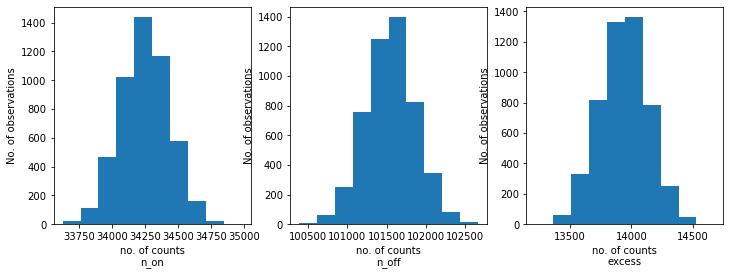

In [13]:

n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:

%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "lambda_": result.parameters["lambda_"].value,
        }
    )

CPU times: user 16min 50s, sys: 4.53 s, total: 16min 54s
Wall time: 17min 28s


In [15]:
results

[{'index': 2.2169905875495766,
  'amplitude': 1.2845712545260467e-12,
  'lambda_': 0.2801792257657554},
 {'index': 2.2324943380030526,
  'amplitude': 1.2364897746094746e-12,
  'lambda_': 0.28570927813929065},
 {'index': 2.236715787152109,
  'amplitude': 1.2640466245835502e-12,
  'lambda_': 0.3058093664482174},
 {'index': 2.2262640878970683,
  'amplitude': 1.2624740793001813e-12,
  'lambda_': 0.302405819333618},
 {'index': 2.2385731783387843,
  'amplitude': 1.276663483135211e-12,
  'lambda_': 0.30673699196054943},
 {'index': 2.1992461618258976,
  'amplitude': 1.3302284553934254e-12,
  'lambda_': 0.3431724199735729},
 {'index': 2.2416099341604867,
  'amplitude': 1.243665549675842e-12,
  'lambda_': 0.2871674134846505},
 {'index': 2.2238247278324987,
  'amplitude': 1.2845374429121784e-12,
  'lambda_': 0.3019087052854374},
 {'index': 2.2235248230739075,
  'amplitude': 1.248766419923766e-12,
  'lambda_': 0.27479277111955186},
 {'index': 2.2589641058301537,
  'amplitude': 1.1745196406545453e-

index: 2.219460463067211 += 0.01831556978459546


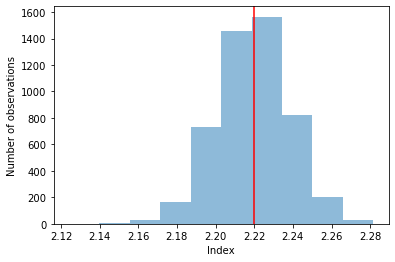

In [16]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel("Index")
plt.ylabel("Number of observations")
print(f"index: {index.mean()} += {index.std()}")

amplitude: 1.2916528392499124e-12 += 4.775463201073527e-14


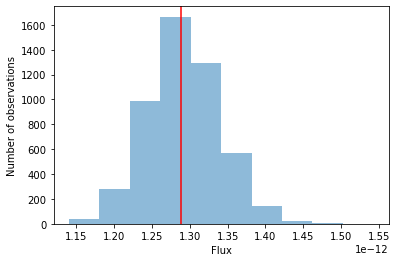

In [17]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel("Flux")
plt.ylabel("Number of observations")
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")

lambda_: 0.30111503478285256 += 0.022834154986024435


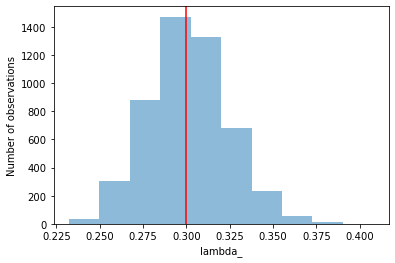

In [18]:
lambda_ = np.array([_["lambda_"] for _ in results])
plt.hist(lambda_, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["lambda_"].value, color="red")
plt.xlabel("lambda_")
plt.ylabel("Number of observations")
print(f"lambda_: {lambda_.mean()} += {lambda_.std()}")